# Second Lab Session: introduction to Monte Carlo methods'

UE Computational Statistics - Aix-Marseille Université / Faculté des Sciences

Author: Antoine Legendre

**Warning**
Remember to put your name in the header of the document.

In this session, we will

- simulate random numbers by inverting the cumulative distribution function,
- reduce the variance of a Monte Carlo estimator by using different methods,
- compare different methods with confidence intervals for the mean.

In [11]:
import numpy as np
import scipy
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Part 1: Inverting the cumulative distribution function

### 1.1 The Weibull distribution

The Weibull distribution $\text{Wei}(\lambda, k)$ is a continuous probability distribution with two parameters:

- $\lambda>0$ is the scale parameter,
- $k>0$ is the shape parameter.

It is often to model the lifetime of objects, that is to say time to failure. In this context, the value of $k$ is critical: if $k<1$, the failure risk decreases over time, if $k=1$, the failure risk is constant over time, and if $k>1$, the failure risk increases over time.

Its probability density function is given, for all $x\in\mathbb R$, by
$$
w(x|\lambda,k) = \frac{k}{\lambda}\left(\frac{x}{\lambda}\right)^{k-1}\exp\left(-\left(\frac{x}{\lambda}\right)^k\right)\mathbf 1\{x\geq 0\}.
$$



**Exercise:**

1. Plot the probability density functions of the Weibull distribution with $\lambda=1$ and $k=0.5, 1, 2, 5,...$ in the same graph. According to you, what is happening when $k$ increases?
2. Show that, when $X\sim\text{Wei}(\lambda, k)$, then $X/\lambda\sim \text{Wei}(1, k)$
3. Compute the cumulative distribution function $W(x|\lambda,k)$ of the Weibull distribution explicitly.
4. Compute the quantile function $W^{-1}(p|\lambda, k)$ of the Weibull distribution explicitly.
5. Show that, the expected value of $X\sim \text{Wei}(\lambda, k)$ is
$$
\mathbb{E}(X)=\lambda\Gamma\left(1+\frac{1}{k}\right), \quad
\text{where } \Gamma(x) = \int_0^\infty t^{x-1}\exp(-t)dt.
$$
Actually $\Gamma(x)$ is Euler's gamma function. It is implemented in the `scipy.special` module.



#### Question 1

/home/administrateur/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2581: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


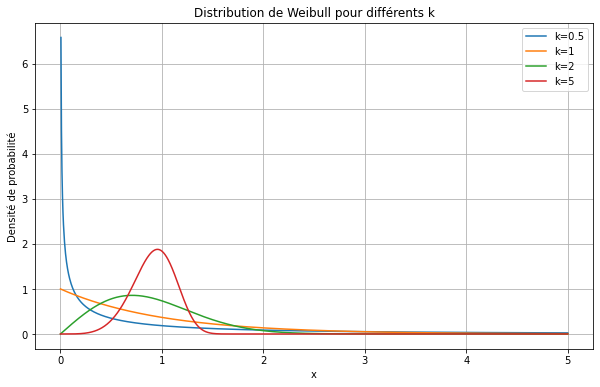

In [12]:
# Question 1
x = np.linspace(0, 5, 1000)
lambda_ = 1
k_values = [0.5, 1, 2, 5]

plt.figure(figsize=(10, 6))
for k in k_values:
    plt.plot(x, stats.weibull_min.pdf(x, k, scale=lambda_), label=f'k={k}')

plt.title('Distribution de Weibull pour différents k')
plt.xlabel('x')
plt.ylabel('Densité de probabilité')
plt.legend()
plt.grid(True)
plt.show()

Lorsque k augmente, la distribution passe d'une forme exponentielle à une forme en cloche avec un mode bien défini.
Pour k<1, la probabilité est très forte pour les petites valeurs de x.
Pour k>1, la distribution présente un pic et devient plus concentrée autour d’une valeur spécifique.
Plus k est grand, plus la distribution ressemble à une gaussienne asymétrique.

#### Question 3

$$ W(x|\lambda,k) = P(X \leq x) = \int_0^x f(t|\lambda,k) \, dt = \int_0^x \frac{k}{\lambda} \left( \frac{t}{\lambda} \right)^{k-1} e^{-(t/\lambda)^k} \, dt $$

On effectue le changement de variable $ u = (t/\lambda)^k $, ce qui implique $ du = k (t/\lambda)^{k-1} (1/\lambda) dt $, soit $ dt = \frac{\lambda}{k} u^{(1-k)/k} du $. 

L'intégrale devient :

$$ W(x|\lambda,k) = \int_0^{(x/\lambda)^k} e^{-u} \, du $$

Or, cette intégrale est l'expression de la fonction de répartition d'une loi exponentielle d'intensité 1, qui vaut $ 1 - e^{-u} $. Ainsi, on obtient :

$$ W(x|\lambda,k) = 1 - e^{-(x/\lambda)^k}, \quad x \geq 0 $$

et $ W(x|\lambda,k) = 0 $ pour $ x < 0 $.

#### Question 2

La densité de $ X $ est donnée par :

$$ f_X(x) = \frac{k}{\lambda} \left( \frac{x}{\lambda} \right)^{k-1} e^{-(x/\lambda)^k}, \quad x > 0 $$

Posons la transformation $ Y = X / \lambda $, soit $ X = \lambda Y $. Alors, la densité de $ Y $ s'obtient en appliquant la règle du changement de variable :

$$ f_Y(y) = f_X(\lambda y) \cdot \left| \frac{d}{dy} (\lambda y) \right| $$

Or,

$$ f_X(\lambda y) = \frac{k}{\lambda} \left( \frac{\lambda y}{\lambda} \right)^{k-1} e^{-(\lambda y/\lambda)^k}
= \frac{k}{\lambda} y^{k-1} e^{-y^k} $$

Et la dérivée de $ X = \lambda Y $ par rapport à $ Y $ est $ \lambda $, donc :

$$ f_Y(y) = \frac{k}{\lambda} y^{k-1} e^{-y^k} \cdot \lambda = k y^{k-1} e^{-y^k}, \quad y > 0 $$

On reconnaît ici la densité d'une loi de Weibull avec paramètres $ \lambda' = 1 $ et $ k $, qui est :

$$ f_Y(y) = k y^{k-1} e^{-y^k}, \quad y > 0 $$

Ainsi, nous avons bien montré que :

$$ Y = \frac{X}{\lambda} \sim \text{Wei}(1, k) $$

#### Question 4

La fonction quantile $ W^{-1}(p|\lambda, k) $ de la loi de Weibull est la fonction réciproque de la fonction de répartition cumulative (CDF), c'est-à-dire qu’elle satisfait :

$$ W(W^{-1}(p|\lambda, k) | \lambda, k) = p $$

La fonction de répartition de la loi de Weibull avec les paramètres $ \lambda > 0 $ et $ k > 0 $ est donnée par :

$$ W(x | \lambda, k) = 1 - e^{-(x/\lambda)^k}, \quad x \geq 0 $$

On cherche $ x $ tel que $ W(x | \lambda, k) = p $, c'est-à-dire :

$$ 1 - e^{-(x/\lambda)^k} = p $$

En isolant l'exponentielle :

$$ e^{-(x/\lambda)^k} = 1 - p $$

En prenant le logarithme des deux côtés :

$$ -(x/\lambda)^k = \ln(1 - p) $$

Puis en multipliant par $ -1 $ :

$$ (x/\lambda)^k = -\ln(1 - p) $$

En prenant la racine $ k $-ième :

$$ x/\lambda = (-\ln(1 - p))^{1/k} $$

Finalement, en multipliant par $ \lambda $, on obtient la fonction quantile :

$$ W^{-1}(p | \lambda, k) = \lambda (-\ln(1 - p))^{1/k} $$

La fonction quantile de la loi de Weibull avec paramètres $ \lambda $ et $ k $ est donnée par :

$$ W^{-1}(p | \lambda, k) = \lambda (-\ln(1 - p))^{1/k}, \quad 0 < p < 1 $$

#### Question 5

$$ \mathbb{E}(X) = \int_0^\infty x \cdot \frac{k}{\lambda} \left( \frac{x}{\lambda} \right)^{k-1} e^{-(x/\lambda)^k} dx $$

Posons :

$$ t = \left( \frac{x}{\lambda} \right)^k \quad \Rightarrow \quad dt = k \left( \frac{x}{\lambda} \right)^{k-1} \frac{dx}{\lambda} $$

Ce qui implique :

$$ dx = \frac{\lambda}{k} t^{(1-k)/k} dt $$

En réécrivant $ x $ en fonction de $ t $ :  

$$ x = \lambda t^{1/k} $$

Substituons dans l'intégrale :

$$ \mathbb{E}(X) = \int_0^\infty \lambda t^{1/k} \cdot \frac{k}{\lambda} t^{(k-1)/k} e^{-t} \cdot \frac{\lambda}{k} t^{(1-k)/k} dt = \lambda \int_0^\infty t^{(1/k)} e^{-t} dt $$

On reconnaît ici la définition de la fonction Gamma :

$$ \Gamma(a) = \int_0^\infty t^{a-1} e^{-t} dt $$

En identifiant $ a - 1 = 1/k $, on obtient :

$$ a = 1 + \frac{1}{k} $$

Ainsi, l'intégrale précédente s'écrit :

$$ \mathbb{E}(X) = \lambda \Gamma\left(1 + \frac{1}{k}\right) $$


### 1.2 Basic Monte Carlo simulations

**Exercise:**

1. Write a function `inverse_cdf` that takes as input (1) $p$ a probability, (2) $\lambda$ and $k$ the parameters of the Weibull distribution and returns the quantile. 
2. Simule a large sample $x_0, x_1,\ldots, x_N$ of size $N=1,000$ from the Weibull distribution with $\lambda=1$ and $k=2$ using the inverse method. 
3. Plot 
$$
\bar x_n = \frac{x_0+\cdots+x_{n-1}}{n}
$$
as a function of $n$ for $n=1,2,\ldots, N$. Add an horizontal line at the expected value of $X$, using the formula of the previous exercise. What is your conclusion?


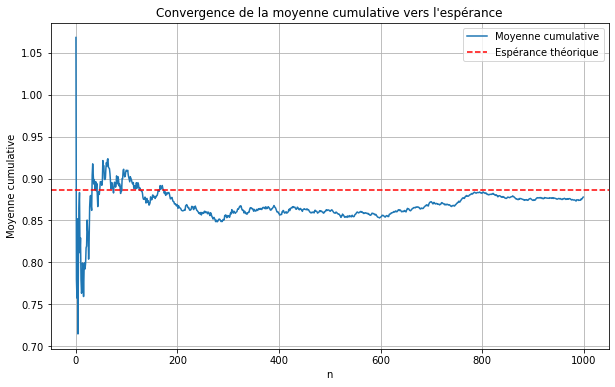

In [13]:
# Question 1
def inverse_cdf(p, lambda_, k):
    return lambda_ * (-np.log(1 - p))**(1/k)

# Question 2 
N = 1000
lambda_ = 1
k = 2
U = np.random.rand(N)
X = inverse_cdf(U, lambda_, k)

# Question 3
cumulative_mean = np.cumsum(X) / np.arange(1, N+1)
expected_value = lambda_ * scipy.special.gamma(1 + 1/k)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_mean, label='Moyenne cumulative')
plt.axhline(expected_value, color='r', linestyle='--', label='Espérance théorique')
plt.title('Convergence de la moyenne cumulative vers l\'espérance')
plt.xlabel('n')
plt.ylabel('Moyenne cumulative')
plt.legend()
plt.grid(True)
plt.show()

La moyenne cumulative converge vers l'espérance théorique de la distribution de Weibull.


### 1.3 Confidence intervals

An asymptotic confidence interval for the mean of a random variable $X$ is given by
$$
\bar x_n \pm z_{1-\alpha/2}\frac{\hat\sigma}{\sqrt n},
$$
where $z_{1-\alpha/2}$ is the quantile of order $1-\alpha/2$ of the standard normal distribution, and $\sigma$ is the standard deviation of $X$.
If $\sigma$ is not available in closed form (which is often the case), we can use the empirical standard deviation
$$
\hat\sigma = \sqrt{\frac{1}{n-1}\sum_{i=0}^{n-1} (x_i-\bar x_n)^2}.
$$
In fact, there is a high chance that, when we resort to Monte Carlo to compute $\mathbb{E}(X)$ numerically, $\mathbb{V}(X)$ is also unknown.

In the case of the Weibull distribution, we can compute the variance of $X$ explicitly. Indeed, we have
$$
\mathbb{V}(X) = \lambda^2\left(\Gamma\left(1+\frac{2}{k}\right)-\Gamma^2\left(1+\frac{1}{k}\right)\right).
$$

**Exercise:**
1. Using the previous simulation, compute the empirical standard deviation of $x_0,\ldots, x_{n-1}$ and both bounds of the asymptotic confidence intervals around $\bar x_n$, for $n=2,\ldots, N$
2. Add the confidence intervals to the previous plot. What is your conclusion?


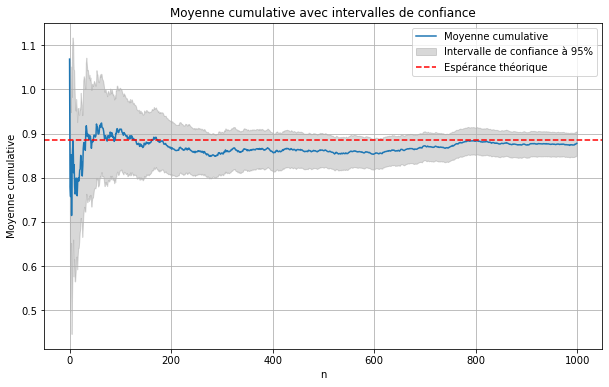

In [14]:
empirical_std = np.sqrt(np.cumsum((X - cumulative_mean)**2) / np.arange(1, N+1))
z = stats.norm.ppf(0.975)  # Quantile à 97.5% pour un intervalle de confiance à 95%
ci_lower = cumulative_mean - z * empirical_std / np.sqrt(np.arange(1, N+1))
ci_upper = cumulative_mean + z * empirical_std / np.sqrt(np.arange(1, N+1))

plt.figure(figsize=(10, 6))
plt.plot(cumulative_mean, label='Moyenne cumulative')
plt.fill_between(range(N), ci_lower, ci_upper, color='gray', alpha=0.3, label='Intervalle de confiance à 95%')
plt.axhline(expected_value, color='r', linestyle='--', label='Espérance théorique')
plt.title('Moyenne cumulative avec intervalles de confiance')
plt.xlabel('n')
plt.ylabel('Moyenne cumulative')
plt.legend()
plt.grid(True)
plt.show()

Les intervalles de confiance se resserrent autour de la moyenne cumulative à mesure que nn augmente, ce qui montre la convergence de l'estimateur Monte Carlo.


## Part 2: Reducing the variance

### 2.1 Antithetic variates

Assume that $Q$ is the quantile function of a distribution with CDF $F$. Assume that $Q$ is an increasing function over $(0;1)$. If $U$ is a random variable uniformly distributed on $[0,1]$, then $Q(U)$ is distributed according to $F$. This is the principle of the inverse method.
On the other hand, $1-U$ is also uniformly distributed on $[0,1]$. Therefore, $Q(1-U)$ is also distributed according to $F$. Using both $Q(U)$ and $Q(1-U)$ is the principle of the antithetic variates method.

**Exercise:**

1. Compare $X=Q(U)$, $Y=Q(1-U)$ and $Q(1/2)$. 
2. Look at Chebyshev's sum inequality and show that $X$ and $Y$ are negatively correlated.
3. Show that $Z=(X+Y)/2$ has the same expected value than $X$, but a smaller variance than $X$ and $Y$.


#### Question 1

#### Question 2

#### Question 3


### 2.2 Antithetic variates applied to the Weibull distribution

**Exercise:**
Apply the antithetic variates method to the Weibull distribution with $\lambda=1$ and $k=2$. Compare the asymptotic confidence intervals given by the sample of $X$ and the sample of $Z$, with graphs. What is your conclusion?



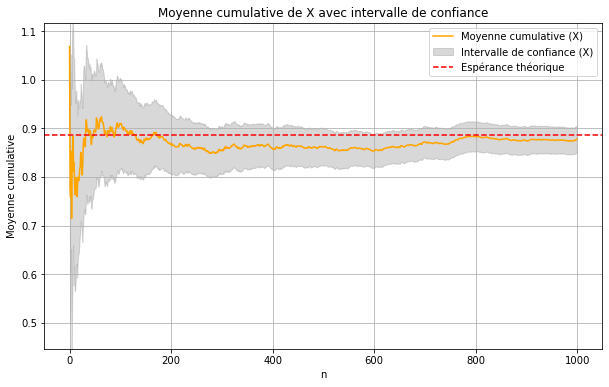

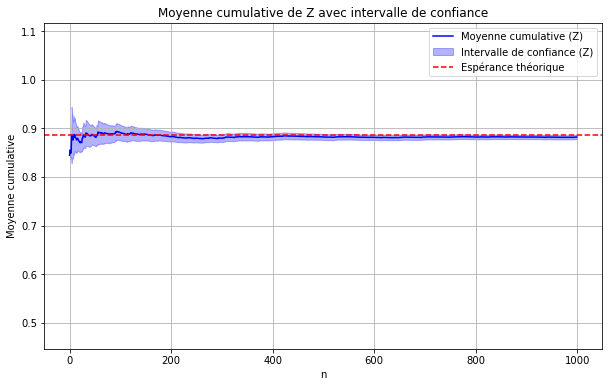

In [15]:
Y = inverse_cdf(1 - U, lambda_, k)
Z = (X + Y) / 2

cumulative_mean_Z = np.cumsum(Z) / np.arange(1, N+1)
empirical_std_Z = np.sqrt(np.cumsum((Z - cumulative_mean_Z)**2) / np.arange(1, N+1))
ci_lower_Z = cumulative_mean_Z - z * empirical_std_Z / np.sqrt(np.arange(1, N+1))
ci_upper_Z = cumulative_mean_Z + z * empirical_std_Z / np.sqrt(np.arange(1, N+1))

plt.figure(figsize=(10, 6))
plt.plot(cumulative_mean, label='Moyenne cumulative (X)', color='orange')
plt.fill_between(range(N), ci_lower, ci_upper, color='gray', alpha=0.3, label='Intervalle de confiance (X)')
plt.axhline(expected_value, color='r', linestyle='--', label='Espérance théorique')
plt.title('Moyenne cumulative de X avec intervalle de confiance')
plt.xlabel('n')
plt.ylabel('Moyenne cumulative')
plt.legend()
plt.grid(True)
plt.ylim(min(min(ci_lower), min(ci_lower_Z)), max(max(ci_upper), max(ci_upper_Z)))
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_mean_Z, label='Moyenne cumulative (Z)', color='blue')
plt.fill_between(range(N), ci_lower_Z, ci_upper_Z, color='blue', alpha=0.3, label='Intervalle de confiance (Z)')
plt.axhline(expected_value, color='r', linestyle='--', label='Espérance théorique')
plt.title('Moyenne cumulative de Z avec intervalle de confiance')
plt.xlabel('n')
plt.ylabel('Moyenne cumulative')
plt.legend()
plt.grid(True)
plt.ylim(min(min(ci_lower), min(ci_lower_Z)), max(max(ci_upper), max(ci_upper_Z)))
plt.show()

La méthode des variables antithétiques réduit la variance de l'estimateur, ce qui se traduit par des intervalles de confiance plus étroits et une courbe plus proche de l'espérance théorique.


### 2.3 Control variates

Assume that $X$ is a random variable and $Y$ is a random variable such that $\mathbb{E}(Y)$ is known. The control variates method consists in estimating $\mathbb{E}(X)$ by
$$
\bar x_n - \beta(\bar y_n - \mathbb{E}(Y)),
$$
where $\bar x_n$ and $\bar y_n$ are the sample means of $X$ and $Y$ respectively, and $\beta$ is the solution of
$$
\beta = \frac{\mathbb{V}(X,Y)}{\mathbb{V}(Y)}.
$$
Often, the value of $\beta$ is unknown. But we can estimate it by
$$
\hat\beta = \frac{\sum_{i=0}^{n-1} (x_i-\bar x_n)(y_i-\bar y_n)}{\sum_{i=0}^{n-1} (y_i-\bar y_n)^2}
$$
and use it in the control variates method.

**Exercise:**

1. Compute the variance of 
$$
Z_n = \bar X_n - \lambda(\bar Y_n - \mathbb{E}(Y))
$$
when $(X_0,Y_0),\ldots, (X_{n-1}, Y_{n-1})$ are i.i.d. samples of a joint distribution whose components can be correlated.
2. Show that the variance is minimal for $\lambda =\beta$
3. What is happening when $X$ and $Y$ are independent? Is the method useful?



#### Question 1



### 2.4 Control variates applied to the Weibull distribution

**Exercise:**

1. Prove that, when $k=1$, $\text{Wei}(\lambda, 1)$ is the exponential distribution with parameter $\lambda$. 
2. The expected value of the exponential distribution is explicit and easy to compute. Compute it explicitly. 
3. Draw a large sample of $(Q(U|\lambda, k), Q(U|\lambda, 1))$ and apply the control variates method to estimate the expected value of $\text{Wei}(\lambda, k)$.
4. Compare the asymptotic confidence intervals given by the sample of $X$ and the sample of $Z$, with graphs. What is your conclusion?
5. Can we combine the antithetic variates and the control variates methods?

#### Question 1

#### Question 2

#### Question 3

#### Question 4

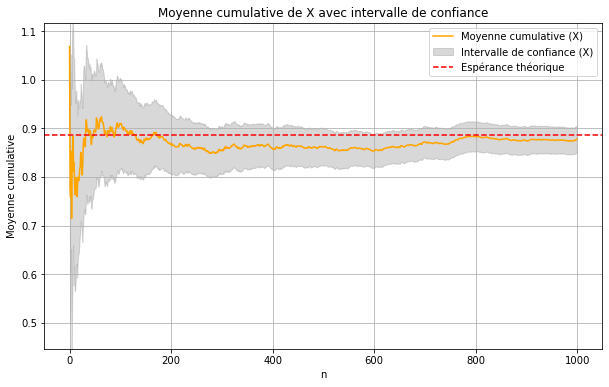

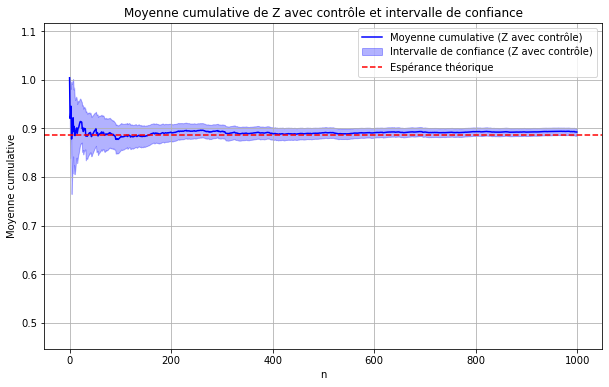

In [ ]:
# Question 4
Y_control = inverse_cdf(U, lambda_, 1)
beta_hat = np.sum((X - np.mean(X)) * (Y_control - np.mean(Y_control))) / np.sum((Y_control - np.mean(Y_control))**2)
Z_control = X - beta_hat * (Y_control - lambda_)

cumulative_mean_Z_control = np.cumsum(Z_control) / np.arange(1, N+1)
empirical_std_Z_control = np.sqrt(np.cumsum((Z_control - cumulative_mean_Z_control)**2) / np.arange(1, N+1))
ci_lower_Z_control = cumulative_mean_Z_control - z * empirical_std_Z_control / np.sqrt(np.arange(1, N+1))
ci_upper_Z_control = cumulative_mean_Z_control + z * empirical_std_Z_control / np.sqrt(np.arange(1, N+1))

plt.figure(figsize=(10, 6))
plt.plot(cumulative_mean, label='Moyenne cumulative (X)', color='orange')
plt.fill_between(range(N), ci_lower, ci_upper, color='gray', alpha=0.3, label='Intervalle de confiance (X)')
plt.axhline(expected_value, color='r', linestyle='--', label='Espérance théorique')
plt.title('Moyenne cumulative de X avec intervalle de confiance')
plt.xlabel('n')
plt.ylabel('Moyenne cumulative')
plt.legend()
plt.grid(True)
plt.ylim(min(min(ci_lower), min(ci_lower_Z), min(ci_lower_Z_control)), max(max(ci_upper), max(ci_upper_Z), max(ci_upper_Z_control)))
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_mean_Z_control, label='Moyenne cumulative (Z avec contrôle)', color='blue')
plt.fill_between(range(N), ci_lower_Z_control, ci_upper_Z_control, color='blue', alpha=0.3, label='Intervalle de confiance (Z avec contrôle)')
plt.axhline(expected_value, color='r', linestyle='--', label='Espérance théorique')
plt.title('Moyenne cumulative de Z avec contrôle et intervalle de confiance')
plt.xlabel('n')
plt.ylabel('Moyenne cumulative')
plt.legend()
plt.grid(True)
plt.ylim(min(min(ci_lower), min(ci_lower_Z), min(ci_lower_Z_control)), max(max(ci_upper), max(ci_upper_Z), max(ci_upper_Z_control)))
plt.show()

La méthode des variables de contrôle réduit également la variance de l'estimateur, ce qui se traduit par des intervalles de confiance plus étroits et une courbe plus proche de l'espérance théorique.

#### Question 5

Oui, il est possible de combiner les deux méthodes pour réduire encore plus la variance de l'estimateur. Cela peut être fait en utilisant à la fois des variables antithétiques et des variables de contrôle dans la même simulation.